In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_context('notebook')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load and look at the data
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Columns age, workclass, education, education.num, marital.status, occupation, relationship, race, sex, hours.per.week, income are self-explanatory.  

fnlwgt, capital.gain, and capital.loss are less obvious.

In [3]:
# Check if there are any missing values
df.shape == df.dropna().shape

True

But just to be sure, let's check every column individually.

In [4]:
def plot_histogram(df, col, bins):
    df[col].hist(bins = bins)
    plt.xlabel(col)
    plt.ylabel('count');

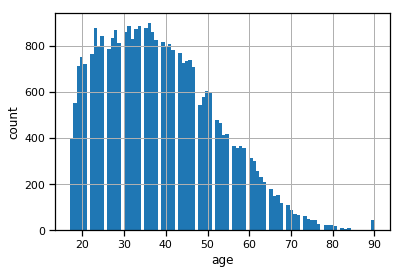

In [5]:
# Check age distribution
plot_histogram(df, 'age', df.age.max())

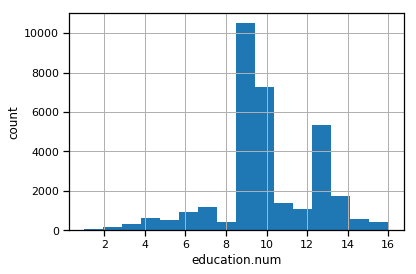

In [6]:
# Check the distribution of years of school
plot_histogram(df, 'education.num', df['education.num'].max())

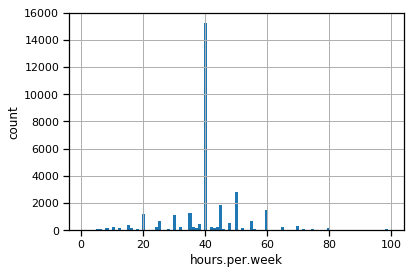

In [7]:
# Look at work hours bar plot
plot_histogram(df, 'hours.per.week', df['hours.per.week'].max())

Since other numeric variables are less intuitive, let's first look at the distribution of values in them to decide on the number of bins.

In [8]:
df['capital.gain'].describe()

count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital.gain, dtype: float64

In [9]:
df['capital.loss'].describe()

count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital.loss, dtype: float64

For capital gain and loss the distribution is very uneven (0 for 75th percentile in both cases), so these features will be discarded when training the model.

In [10]:
df.fnlwgt.describe()

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64

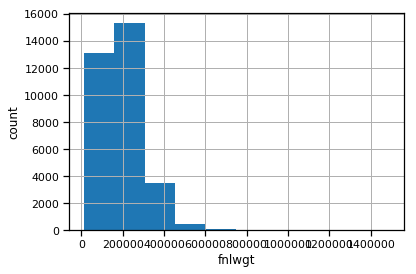

In [11]:
# Check fnlwgt distribution
plot_histogram(df, 'fnlwgt', 10)

Plot data with 99% quantile cutoff to remove outliers.

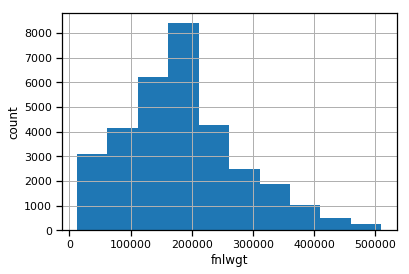

In [12]:
plot_histogram(df[df.fnlwgt <= df.fnlwgt.quantile(0.99)], 'fnlwgt', 10)

To make this feature more meaningful, only the data below 99th percentile will be included for model training.

Now take a look at categorical values.

In [13]:
for col in df.columns.values:
    if df[col].dtype == object:
        print(col.upper(), ':', df[col].unique())
        print()

WORKCLASS : ['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']

EDUCATION : ['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']

MARITAL.STATUS : ['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']

OCCUPATION : ['?' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty' 'Other-service'
 'Adm-clerical' 'Craft-repair' 'Transport-moving' 'Handlers-cleaners'
 'Sales' 'Farming-fishing' 'Tech-support' 'Protective-serv' 'Armed-Forces'
 'Priv-house-serv']

RELATIONSHIP : ['Not-in-family' 'Unmarried' 'Own-child' 'Other-relative' 'Husband' 'Wife']

RACE : ['White' 'Black' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']

SEX : ['Female' 'Male']

NATIVE.COUNTRY : ['United-States' '?' 'Mexico' 'Greece' 'Vietnam' 'China' 'Taiwan' 'India'
 'Philippin

In [14]:
# Take a look at countries of origin
df['native.country'].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

There are too many countries to turn into dummy variables. We could bucket them by geographic location/continents, but such bucketing will likely introduce an even bigger error. I believe there is much more to immigration patterns that a machine learning model will be able to caprture. There is also an issue of legality and discrimination against people from different countries, so for the sake of this project, I will drop this column altogether.

occupation and workclass have values ' ?', so take a deeper look into these.

In [15]:
print('Percentage of missing data for occuptation:', 
      round(df[df['occupation'] == '?'].shape[0] / df.shape[0], 4))
print('Percentage of missing data for workclass:', 
      round(df[df['workclass'] == '?'].shape[0] / df.shape[0], 4))

Percentage of missing data for occuptation: 0.0566
Percentage of missing data for workclass: 0.0564


Since percentage of missing data for both columns is very close, let's see if they both are missing at the same time.

In [16]:
df[(df['occupation'] == '?') & (df['workclass'] == '?')].head(4)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
14,51,?,172175,Doctorate,16,Never-married,?,Not-in-family,White,Male,0,2824,40,United-States,>50K
24,61,?,135285,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,2603,32,United-States,<=50K


Occupation and workclass seem important for determining income, and since they are missing only about 5% of the time, the missing values will be dropped the sake of this assignment.

'relationship' column carries very little useful information, since there already are 'marital_status' and 'sex' columns, so this column will be dropped to reduce potential feature space.

Now, look at class balance/imbalance.

In [17]:
df.income.value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

In [18]:
print("Class '{0}': {1:1.1f}%".format(df.income.value_counts().index[0], \
                                      round(df.income.value_counts()[0]/len(df), 2)*100))
print("Class '{0}': {1:1.1f}%".format(df.income.value_counts().index[1], \
                                      round(df.income.value_counts()[1]/len(df), 2)*100))

Class '<=50K': 76.0%
Class '>50K': 24.0%


So the classes ratio is about 3:1, which means they are fairly balanced (as opposed to something like 20:1 ratio). However, balancing can be adjusted for when modeling.

In summary, I will get rid of the country of origin column for ethical reasons and drop 'relationship', 'capital_gain', 'capital_loss' columns. The relationship columns is dropped because it's already described by marital status and sex columns.